
# Postal codes clustering of the city of Toronto, Canada, using the venues density
## Introduction
In this notebook is presented the segmentation and clustering of the Postal codes division of the city of Toronto in the province of Ontario, Canada, extracted from "List of postal codes of Canada: M" in Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). The Foursquare API was used to find the venues on each postal code zone using a radius based on the area cover by each postcode without overlapping between them and a maximum number of venues per postal code of 100. Using K-Means clustering algorithm, the postal codes were grouped based on the venues density (venues/area) and the result was showed on a map of Toronto.

In [1]:
pip install folium

    100% |████████████████████████████████| 92kB 1.8MB/s ta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install BeautifulSoup4

    100% |████████████████████████████████| 102kB 1.3MB/s a 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.



## 1. Extract data of Toronto neighborhoods from Wikipedia
BeautifulSoup library is used to scrape the Wikipedia's article that contains the Toronto neighborhood. The neighborhood data presented in a Table on the article is parsed and stored in a list that contains each row of the table, that is the Postcode, Borough and Neighborhood name.

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text #get the entire html of the article as a str
html_parsed_result = BeautifulSoup(text_result, 'html.parser') #transform the text to html

neightborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neightborhood_rows = neightborhood_info_table.find_all('tr')

# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neightborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neightborhood_info.append(info)
    
neightborhood_info[0:10]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned']]

In [5]:
#create a Neighborhoods dataframe
neightborhood_info[0][-1] = 'Neighborhood' # change to american spelling
neighborhood_df = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned



## 2. Explore and clean neighborhoods dataset
The data returned has missing info like "Not assigned" boroughs and neighborhoods.

In [6]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Not assigned Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

The DataFrame shape is (288, 3) 

There are:
  180 Postal codes
  11 Boroughs
  208 Neighborhoods
  77 rows with Not assigned Borough
  78 rows with Not assigned Neighborhood
  77 rows with Not assigned Neighborhood and Borough 



In [7]:
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [8]:
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [9]:
print('After cleaning the DataFrame, its new shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0]))

After cleaning the DataFrame, its new shape is (211, 3) 

There are:
  103 Postal codes
  11 Boroughs
  209 Neighborhoods


In [10]:
group = neighborhood_df.groupby('Postcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postcode', 'Borough', 'Neighborhood']

grouped_df.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


the .shape method to print the number of rows of your dataframe.

In [11]:
print('The DataFrame shape is', grouped_df.shape)

The DataFrame shape is (103, 3)


In [12]:
coordinates_df = pd.read_csv('Geospatial_Coordinates.csv') # transform the csv file into a dataframe

print('The coordinates dataframe shape is', coordinates_df.shape)
coordinates_df.head()

The coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
postcodes_with_coordinates_df = grouped_df.join(coordinates_df.set_index('Postal Code'), on='Postcode')

postcodes_with_coordinates_df.head(16)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [15]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map



The map shows that the Postal codes are not evenly spaced, and the area cover by some of them, using a radius of 500 meters, overlaps. A different radius for each postcode results in a better venues search because that will avoid misrepresentation of the number of venues per postcode caused by too large or low radius values.

In [16]:
import matplotlib.pyplot as plt

X = postcodes_with_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

<Figure size 1500x1000 with 1 Axes>

In [17]:
pip install geopy

    100% |████████████████████████████████| 102kB 1.3MB/s a 0:00:011
  Stored in directory: /home/jovyan/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
Note: you may need to restart the kernel to use updated packages.


In [18]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [19]:
coordinates = postcodes_with_coordinates_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


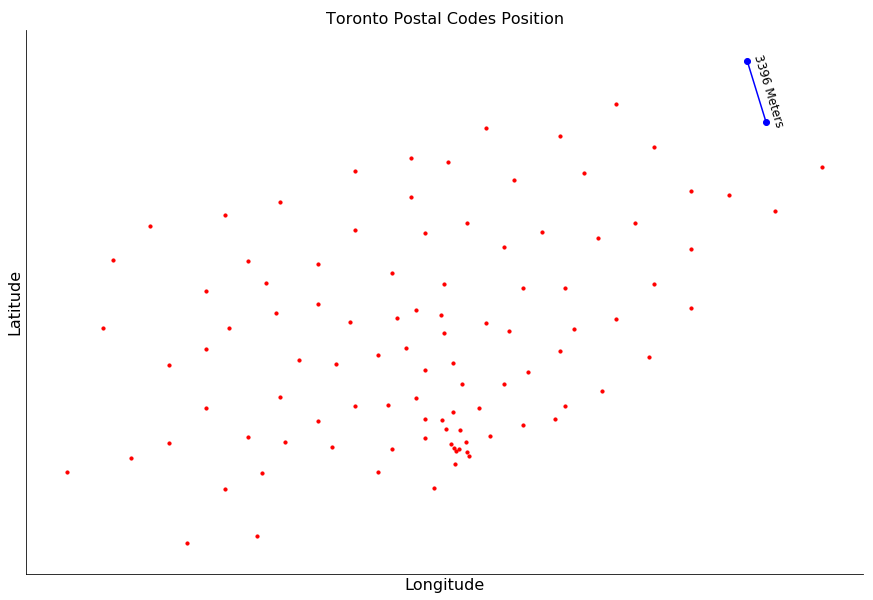

In [20]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [21]:
from math import isnan

for lat, lng, idx in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postcodes_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postcodes_with_coordinates_df.head(15)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1301.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1112.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1112.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


The map is plotted using different radius for each postal code. Now not only overlapping was avoided but more area of the city is cover, consequently, more venues are retrieved

In [22]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

Next thing to do is explore each Postcode to get venues using the Foursquare API. For that, the credential must be declared

## 3. Get Venues
In order to get the venues in the perimeter of each Postal code, it is necessary to get the geographical coordinates (lat and lng) of each one of those and add them to the dataframe. The geopy library is not compatible with Canada's postcode and geocoder is an unreliable library. For that reason the coordinates are in the csv file 'Geospatial_Coordinates.csv".

In [23]:
CLIENT_ID = 'IBTFCHR5MHHEIHE1HYWSHIN4W54LZ31UTAKQ2LIJZDQ3IVEX' 
CLIENT_SECRET = 'CBBDV5WRMN5BLR1C442PQJTZPT4BBHDGHJMN1MUJCJDFVCHH' 
VERSION = '20181102'

To explore the data returned by the Foursquare API, a maximum of 100 venues from the first postcode are requested in a radius of 500 meters.

In [24]:
#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [25]:
first_postcode = postcodes_with_coordinates_df.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=IBTFCHR5MHHEIHE1HYWSHIN4W54LZ31UTAKQ2LIJZDQ3IVEX&client_secret=CBBDV5WRMN5BLR1C442PQJTZPT4BBHDGHJMN1MUJCJDFVCHH&ll=43.7635726,-79.1887115&v=20181102&radius=1205.0&limit=100'

In [26]:
#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

In [27]:
venues_df = get_venues(url)

venues_df.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bc366dab492d13a51b2a860-0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",4bc366dab492d13a51b2a860,4449 Kingston Road,CA,Scarborough,Canada,at Lawrence and Morningside,579,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'label': 'display', 'lat': 43.76875171771289...",43.768752,-79.187982,M1E 2N7,ON,Chick-N-Joy,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b3a9504f964a520646a25e3-1,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",4b3a9504f964a520646a25e3,4525 Kingston Rd.,CA,Toronto,Canada,at Lawrence Ave. E,944,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'label': 'display', 'lat': 43.77146181777272...",43.771462,-79.184384,M1E 2P1,ON,LCBO,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ba164fdf964a52039b337e3-2,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",4ba164fdf964a52039b337e3,4525 Kingston Rd,CA,West Hill,Canada,Morningside Crossing,933,"[4525 Kingston Rd (Morningside Crossing), West...","[{'label': 'display', 'lat': 43.77134173380578...",43.771342,-79.184341,NaN,ON,Bulk Barn,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c9fdb04542b224bca4201a0-3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",4c9fdb04542b224bca4201a0,4218 Lawrence Avenue East,CA,Scarborough,Canada,NaN,701,"[4218 Lawrence Avenue East, Scarborough ON M1E...","[{'label': 'display', 'lat': 43.76904597684398...",43.769046,-79.184386,M1E 4X9,ON,Little Caesars Pizza,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b6074e3f964a5200fe729e3-4,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",4b6074e3f964a5200fe729e3,4410 Kingston Rd,CA,Scarborough,Canada,NaN,469,"[4410 Kingston Rd, Scarborough ON M1E 2N5, Can...","[{'label': 'display', 'lat': 43.76769708292701...",43.767697,-79.189914,M1E 2N5,ON,Swiss Chalet Rotisserie & Grill,0,[]


In [28]:
#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",43.768752,-79.187982,Chick-N-Joy
1,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",43.771462,-79.184384,LCBO
2,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",43.771342,-79.184341,Bulk Barn
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.769046,-79.184386,Little Caesars Pizza
4,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.767697,-79.189914,Swiss Chalet Rotisserie & Grill


In [29]:
venues_df.loc[0, 'Category']

[{'id': '4d4ae6fc7a7b7dea34424761',
  'name': 'Fried Chicken Joint',
  'pluralName': 'Fried Chicken Joints',
  'shortName': 'Fried Chicken',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
   'suffix': '.png'},
  'primary': True}]


It is necessary to extract the Category (shortName) of the JSON data

In [30]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Fried Chicken Joint,43.768752,-79.187982,Chick-N-Joy
1,Liquor Store,43.771462,-79.184384,LCBO
2,Food & Drink Shop,43.771342,-79.184341,Bulk Barn
3,Pizza Place,43.769046,-79.184386,Little Caesars Pizza
4,Pizza Place,43.767697,-79.189914,Swiss Chalet Rotisserie & Grill
5,Smoothie Shop,43.770668,-79.184150,Booster Juice
6,Coffee Shop,43.770367,-79.186313,Starbucks
7,Breakfast Spot,43.772319,-79.184900,Sunset Grill
8,Beer Store,43.769793,-79.187505,The Beer Store
9,Pharmacy,43.770282,-79.185012,Shoppers Drug Mart


Next step is to get venues for each postal code

In [31]:
#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [32]:
all_venues = get_all_venues(postcodes_with_coordinates_df['Postcode'], postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned is  3329


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
2,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
3,M1B,43.806686,-79.194353,penguin exhibit,43.819435,-79.185959,Zoo Exhibit
4,M1B,43.806686,-79.194353,Lion Exhibit,43.819228,-79.186977,Zoo Exhibit
5,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
6,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit
7,M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
8,M1B,43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store
9,M1B,43.806686,-79.194353,Harvey's,43.800106,-79.198258,Fast Food Restaurant


In [33]:
print('Total Toronto postcodes:', postcodes_with_coordinates_df['Postcode'].shape[0])
print('Total Toronto postcodes with venues:', all_venues['Postcode'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


In [34]:
postcodes_diff = np.setdiff1d(postcodes_with_coordinates_df['Postcode'].values,all_venues['Postcode'].unique())
postcodes_with_coordinates_df[postcodes_with_coordinates_df['Postcode']==postcodes_diff[0]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


## 4. Analyze venues data
In order to get a better sense of the best way of clustering the postalcodes, it's necessary to analyze the venues data returned by Foursquare.

In [35]:
venues_in_postcode = all_venues.groupby('Postcode').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['Postcode', '# of Venues']).set_index('Postcode').join(postcodes_with_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head(10)

,Postcode,# of Venues,Distance
0,M1B,33,1698
1,M1C,9,1625
2,M1E,29,1205
3,M1G,4,913
4,M1H,22,913
5,M1J,22,1301
6,M1K,23,1112
7,M1L,34,1052
8,M1M,18,1112
9,M1N,15,1297


In [36]:
venues_in_postcode[['# of Venues']].describe()

,# of Venues
count,103.000000
mean,32.320388
std,26.021188
min,0.000000
25%,12.500000
50%,25.000000
75%,45.500000
max,100.000000


The minimum amount of venues present on a postcode is 0, as we add M5E, and the maximum is 100, expected given the limit of venues set on the request sent to the Foursquare API. 50% of the venues presents 26 or less venues.

The venues Frequency Distribution of the number of venues is presented next

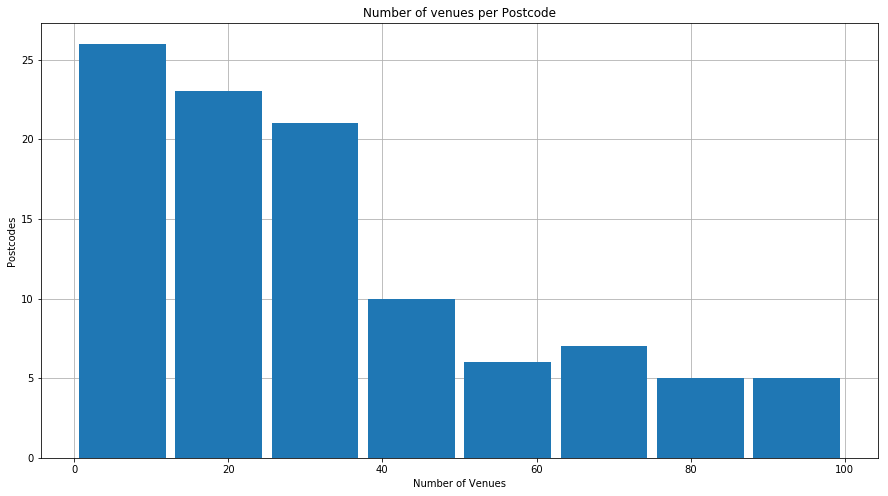

In [37]:
venues_in_postcode['# of Venues'].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Number of venues per Postcode')
plt.show()

Given that each postcode has a different radius passed to the venues request, it's better to represent the venues per postcode in terms of density, that's venues per are cover for each postcode, in this case the area cover in the venues search defined by the distance to the closest postcode.

In [38]:
density_venues_in_postcode = all_venues.groupby('Postcode').count()

density_venues_in_postcode = pd.DataFrame(list(zip(density_venues_in_postcode.index, density_venues_in_postcode['Venue'])), 
                                  columns=['Postcode', 'Density']).set_index('Postcode').join(postcodes_with_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
density_venues_in_postcode['Density'] = np.int64(density_venues_in_postcode['Density']/(density_venues_in_postcode['Distance']/1000)) #distance in km
density_venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_postcode.head(10)

,Postcode,Density,Distance
0,M1B,19,1698.0
1,M1C,5,1625.0
2,M1E,24,1205.0
3,M1G,4,913.0
4,M1H,24,913.0
5,M1J,16,1301.0
6,M1K,20,1112.0
7,M1L,32,1052.0
8,M1M,16,1112.0
9,M1N,11,1297.0


In [39]:
density_venues_in_postcode[['Density']].describe()

,Density
count,103.000000
mean,45.902913
std,48.586998
min,0.000000
25%,15.000000
50%,29.000000
75%,58.500000
max,274.000000


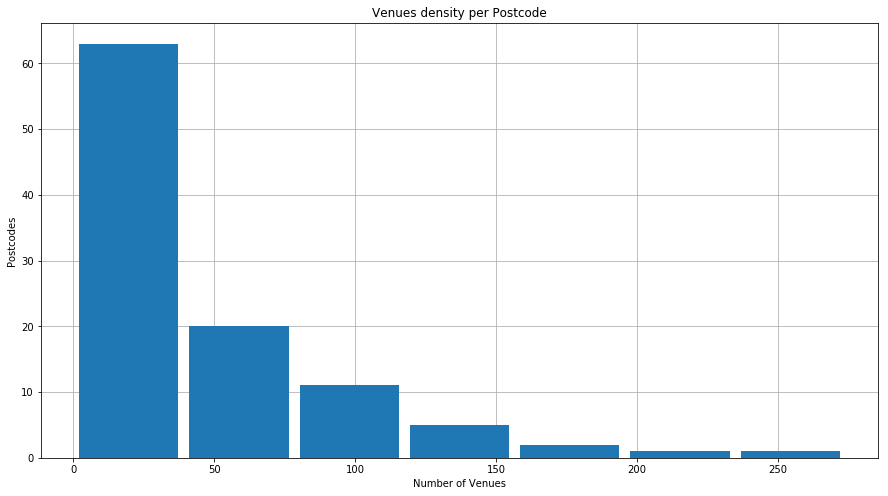

In [40]:
density_venues_in_postcode['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Venues density per Postcode')
plt.show()


THe histogram shows that 60% of the postcodes presents a density between 0 and 30 venues per area (expressed as radius). That is expected given that Toronto has a low population density. The last three bars on the plot have very low values, it could be possible to merge that data and use 5 venues density ranges for the clustering


## 5. Cluster Postcodes
Next the postcodes are clustered based on venues density. One important hyperparameter is the number of clusters and based on previous analysis a tentative value is five clusters. Next the elbow method is used to have a better sense of the optimal number.

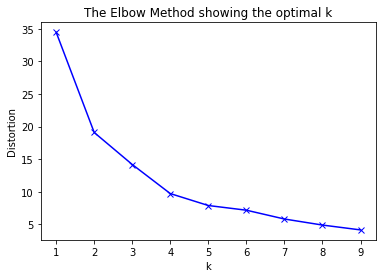

In [41]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_postcode['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_postcode['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [42]:
num_clusters = 5

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[0 0 0 0 0 0 0 3 0 0 3 0 3 3 3 3 0 0 3 0 0 3 1 0 3 3 0 3 3 0 0 0 0 0 0 0 0
 1 1 3 3 4 3 4 0 0 3 1 0 1 0 4 2 1 2 1 1 4 2 1 4 3 0 0 3 3 2 3 1 1 3 3 0 0
 3 3 4 1 0 0 3 1 1 1 0 3 3 3 3 3 0 3 0 0 0 0 0 0 0 0 0 0 0]


In [43]:
density_venues_in_postcode['Cluster'] = k_means.labels_
density_venues_in_postcode.head(10)

,Postcode,Density,Distance,Cluster
0,M1B,19,1698.0,0
1,M1C,5,1625.0,0
2,M1E,24,1205.0,0
3,M1G,4,913.0,0
4,M1H,24,913.0,0
5,M1J,16,1301.0,0
6,M1K,20,1112.0,0
7,M1L,32,1052.0,3
8,M1M,16,1112.0,0
9,M1N,11,1297.0,0



## 6. Examine clusters
Check the centroids values of venues density and postcodes per cluster

In [44]:
centroids = np.int64(round(density_venues_in_postcode.groupby('Cluster').mean()['Density']))
frecuency = density_venues_in_postcode.groupby('Cluster').count()['Postcode']

cluster_info = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Postcodes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Postcodes
0,0,13,47
1,3,39,31
2,1,84,15
3,4,125,6
4,2,218,4


Based on the centroids of each cluster, the cluster names can be defined as:

'Low Venues Density': Centroid equal to 11 <br>
'Medium-Low Venues Density' with a centroid equal to 33 <br>
'Medium-High Venues Density' with a centroid equal to 72<br>
'High Venues Density' with a centr0id equal to 114<br>
'Very High Venues Density' with a centroid equal to 211<br>

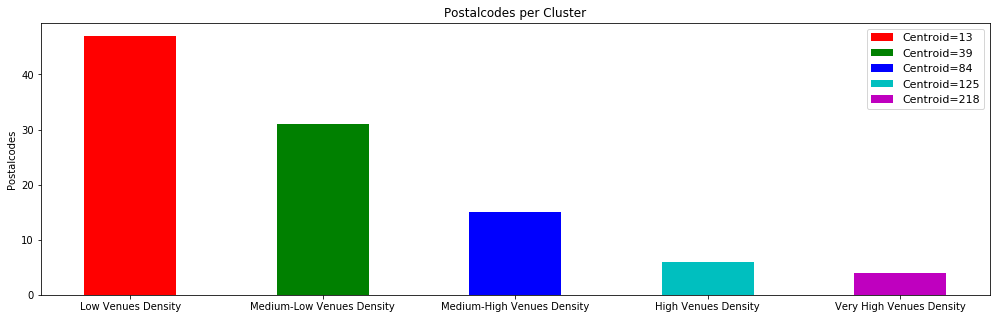

In [45]:
fig, ax = plt.subplots(figsize=(17,5))
clusters= ['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density']
colors = ['r','g','b','c','m']
legend = []

for id, cluster in enumerate(clusters):
    legend.append('Centroid={}'.format(cluster_info['Centroid'][id]))
    bar = ax.bar(cluster, cluster_info['Postcodes'][id], 0.48, color=colors[id])

ax.set_ylabel('Postalcodes')
ax.set_title('Postalcodes per Cluster')
# ax.set_facecolor((1,1,1))
# ax.grid(True, axis='y',color='k', linestyle='-', linewidth=1)

plt.legend(legend, fontsize=11)

plt.show()


In [46]:
postcodes_with_coordinates_df = pd.concat([postcodes_with_coordinates_df[:56],postcodes_with_coordinates_df[57:],postcodes_with_coordinates_df[56:57]]) #move M5E to the last row
postcodes_with_coordinates_df['Cluster'] = k_means.labels_

colors = ['red','green','blue','cyan','magenta']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=location[-2],
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map

# Usage
The results showed on the map could be useful, among others, in:

1.Real estate: as part of property cost model (venues density could be related to the cost of a property) or as a tool for property search.<br>
2.Epidemiology research: venues density could be related with noise, pollution or crime.